In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('../data/raw_data/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])


In [3]:
dataset.movie_id.nunique()

9066

In [4]:
# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])


In [7]:
dataset.user_id

0           1
1           1
2           1
3           1
4           1
         ... 
99999     671
100000    671
100001    671
100002    671
100003    671
Name: user_id, Length: 100004, dtype: int64

In [1]:
num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_movies)
print('Number of users', num_users)

Number of movies 9066
Number of users 671


In [2]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (80003, 4)
test shape:  (20001, 4)


In [3]:
dataset.dtypes

user_id        int64
movie_id       int64
rating       float64
timestamp      int64
dtype: object

In [4]:
dataset.head(60)

,user_id,movie_id,rating,timestamp
0,1,1,2.5,1260759144
1,1,2,3.0,1260759179
2,1,3,3.0,1260759182
3,1,4,2.0,1260759185
4,1,5,4.0,1260759205
5,1,6,2.0,1260759151
6,1,7,2.0,1260759187
7,1,8,2.0,1260759148
8,1,9,3.5,1260759125
9,1,10,2.0,1260759131


In [5]:
train

,user_id,movie_id,rating,timestamp
8713,56,3490,4.0,1467007838
73656,514,2083,3.0,853892993
75298,522,6815,1.0,1391374847
54141,388,2261,1.0,946524403
64854,463,100,5.0,1049913589
...,...,...,...,...
4787,26,31,3.5,1360088114
80713,547,8235,1.5,1398810847
15252,99,350,2.0,1015038093
64860,463,58,3.0,1049924031


In [6]:
train.movie_id.nunique()


8370

In [7]:
num_movies

9066

In [8]:
import pydot
import graphviz
%matplotlib inline

from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate
from tensorflow.keras.utils import model_to_dot
#from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

2021-08-27 17:19:30.763523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-27 17:19:30.763603: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
from keras.layers import dot

# Let's use a higher latent dimension.
latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = dot([movie_vec, user_vec], axes=1, normalize=False)

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')


2021-08-27 17:19:39.584413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-27 17:19:39.584509: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-27 17:19:39.584555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-27 17:19:39.584929: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


AttributeError: 'NoneType' object has no attribute 'create'

In [12]:
print('user_input',user_input.shape)
print('movie_input',movie_input.shape)

user_input (None, 1)
movie_input (None, 1)


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 10)        90670       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        6720        user-input[0][0]                 
______________________________________________________________________________________________

In [14]:
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)


2021-08-27 17:19:46.314152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
2501/2501 [==============================] - 7s 3ms/step - loss: 11.6217
Epoch 2/10
2501/2501 [==============================] - 7s 3ms/step - loss: 3.9438
Epoch 3/10
2501/2501 [==============================] - 7s 3ms/step - loss: 2.0028
Epoch 4/10
2501/2501 [==============================] - 7s 3ms/step - loss: 1.3902
Epoch 5/10
2501/2501 [==============================] - 7s 3ms/step - loss: 1.1139
Epoch 6/10
2501/2501 [==============================] - 12s 5ms/step - loss: 0.9634
Epoch 7/10
2501/2501 [==============================] - 7s 3ms/step - loss: 0.8709
Epoch 8/10
2501/2501 [==============================] - 8s 3ms/step - loss: 0.8095
Epoch 9/10
2501/2501 [==============================] - 8s 3ms/step - loss: 0.7655
Epoch 10/10
2501/2501 [==============================] - 8s 3ms/step - loss: 0.7310


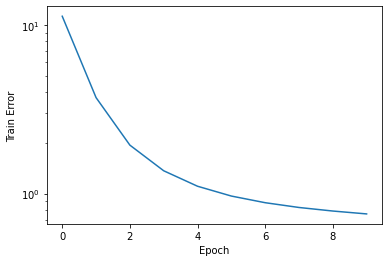

0.7953432326205401

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)